Titanic Dataset EDA Analysis

Let's look at the data at large first

In [1]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from src.utils.utility_functions import SelectColumnsTransformer
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import style
style.use('seaborn-darkgrid')

In [2]:
#Loading the data analysing datasets columns and shape
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df = pd.read_csv('data/train.csv')
df_train.head(5)
print('Dataframe columns are :' + str(df_train.shape))
df_train.info()

Dataframe columns are :(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Training data includes information regarding 891 passengers. The information includes:
* PassengerId: Passenger ID
* Survived: whether or not the passenger survived the accident
* Pclass: Passenger class
* Name: Passenger name
* Sex: Passenger sex
* Age: Passenger age
* SibSp: Passenger ???
* Parch: Passenger ???
* Ticket: Passenger Ticket
* Fare: Passenger Ticket Cost
* Cabin: Passenger cabin class
* Embarked: Passenger port of entry

Let's look at the data at large first

In [3]:
#missing data

total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()
df_train.columns = [col.lower() for col in df_train.columns]
df_train.index = df_train['passengerid']

Out of the 11 available independent variables, the variables of "PassengerId", "Name", "Parch" &
"Ticket" are believed to be
irrelevant to whether a passenger has survived or not and therefore these columns are dropped for the
initial analysis.
There are missing values in three fields of "Cabin", "Age" and "Embarked".
With about 77 percent of data missing from "Cabin" field, this variable will be excluded from modeling efforts.
In case of "Embarked", there are two cases of missing values and rows with missing values will be dropped.

In [4]:
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'survived']
selector_preprocessing = Pipeline([('selector', SelectColumnsTransformer(cols))])
df_train = selector_preprocessing.fit_transform(X=df_train)
df_train = df_train[df_train['embarked'].notna()]

Predictor variables are examined and their correlation with survival rate are analysed using Chi-squared
test along with the relative frequency bar plots. It can be seen that, variables "sex", "pclass" and
are "Embarked" are highly correlated with the survival rate. Female and first class
passenger had higher survival rate.

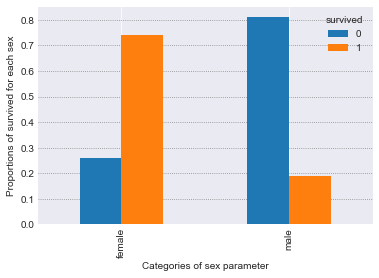

p-value=0.000000, significance=0.05

At 0.05 level of significance, we reject the null hypotheses and accept H1.
    They are not independent.


In [5]:
from scipy.stats import chi2_contingency

def analysis_cat_dependency(dataframe, var_v, var_h, is_plot=True):
    df2 = dataframe.groupby([var_v, var_h]).size().reset_index(name='Count')
    df_count = pd.pivot_table(df2, values='Count', columns=[var_v], index=[var_h], aggfunc=np.sum)
    # df_ratio_val_1 = df_count.div(df_count.sum(axis=0), axis=1)
    df_ratio_val_2 = df_count.div(df_count.sum(axis=1), axis=0)
    if is_plot:
        ax = df_ratio_val_2.plot(kind='bar')
        ax.set_xlabel('Categories of %s parameter' %var_h)
        ax.set_ylabel('Proportions of %s for each %s' %(var_v,var_h))
        ax.grid(1, which='major', axis='y', color='gray', ls=':')
        plt.show()

    chi, pval, dof, exp = chi2_contingency(df_count)
    significance = 0.05
    print('p-value=%.6f, significance=%.2f\n' % (pval, significance))
    if pval < significance:
        print("""At %.2f level of significance, we reject the null hypotheses and accept H1.
    They are not independent.""" % significance)
    else:
        print("""At %.2f level of significance, we accept the null hypotheses.
    They are independent.""" % significance)
    return df_count, exp

a = analysis_cat_dependency(df_train, 'survived', 'sex')

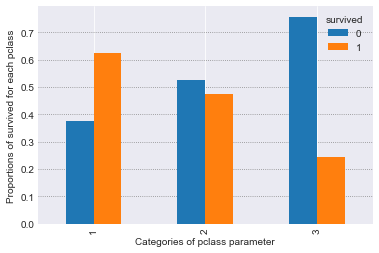

p-value=0.000000, significance=0.05

At 0.05 level of significance, we reject the null hypotheses and accept H1.
    They are not independent.


In [6]:
a = analysis_cat_dependency(df_train, 'survived', 'pclass')

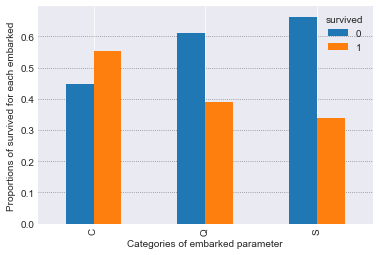

p-value=0.000002, significance=0.05

At 0.05 level of significance, we reject the null hypotheses and accept H1.
    They are not independent.


In [7]:
a = analysis_cat_dependency(df_train, 'survived', 'embarked')

The correlations for numeric variables "fare" and "age" with survival rate
are analysed via box plots and correlation matrix.
Variable "fare" is highly correlated with survival rate as passengers who paid higher ticket prices
survived at a higher rate. "age" is also correlated but not as much as other variables.

<AxesSubplot:>

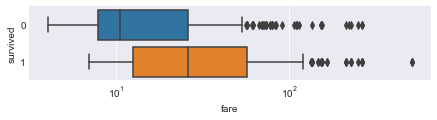

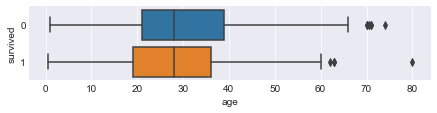

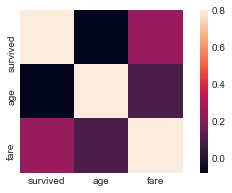

In [8]:
fare_box = sns.catplot(x="fare", y="survived", kind="box", orient="h", height=1.5, aspect=4,
                data=df_train.query("fare > 0"))
fare_box.set(xscale="log")

age_box = sns.catplot(x="age", y="survived", kind="box", orient="h", height=1.5, aspect=4,
                data=df_train)
num_corrmat = df_train[['survived','age','fare']].corr()
d, ax = plt.subplots(figsize=(6,3))
sns.heatmap(num_corrmat,vmax=0.8,square=True)

### Addressing Missing Values

The preprocessing steps are discussed and put into a pipeline to make the process more reproducible.
* Numeric features
    * Missing valuers of numeric features "age" is replaced by median of the column
    * The values are standardized
* Categorical features
    * Missing values already addressed
    * Columns converted into one-hot
* Both pipelines put together as pre-process pipeline

In [10]:
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

y_tr = df_train['survived']
x_tr = df_train.drop('survived',axis=1)

In [11]:
from xgboost import XGBClassifier
xgboost_clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('xgb_clf', XGBClassifier())])
xgboost_clf.fit(x_tr,y_tr)
print('XGBoost model score %.2f' % xgboost_clf.score(x_tr,y_tr))

XGBoost model score 0.96
